#**Project: Handwritten Digit Generation using DCGAN**

###**1. Objective**
The goal of this project is to build a Generative AI model capable of creating realistic, new handwritten digits (0-9). This demonstrates mastery of **Unsupervised Learning** and **Generative Adversarial Networks (GANs)**, which are the foundational technology behind modern AI art and content generation.

###**2. Methodology (Technique Used: Deep Convolutional GAN)**
I implemented a **DCGAN (Deep Convolutional Generative Adversarial Network)** using TensorFlow and Keras. The architecture consists of two competing neural networks:

- **The Generator:** A "Artist" network that takes random noise (latent vector) as input and upsamples it using Transposed Convolutional layers to generate a 28x28 pixel image. It learns to fool the discriminator.
- **The Discriminator:** A "Critic" network (a standard CNN classifier) that evaluates images and tries to distinguish between real MNIST images and fake ones produced by the generator.

###**3. Training Process**
The two models are trained simultaneously in a zero-sum game:

1. The Generator tries to minimize the probability that the Discriminator identifies its output as fake.
2. The Discriminator tries to maximize its accuracy in distinguishing real from fake.
3. Over time, the Generator learns to produce highly realistic digits that are indistinguishable from the training data.

###**Install & Import Libraries**

I need `imageio` to create animations (GIFs) of the digits improving over time.

In [1]:
# Install necessary libraries for visualization
!pip install -q imageio

import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from IPython import display

print(f"TensorFlow Version: {tf.__version__}")
print("Libraries imported successfully.")

TensorFlow Version: 2.19.0
Libraries imported successfully.


###**Load and Preprocess Data**

I use the MNIST dataset. Note that I normalize images to `[-1, 1]` because GANs usually use `tanh` activation in the final layer.

In [2]:
# 1. Load MNIST Data
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# 2. Reshape and Normalize
# Reshape to (Batch_Size, 28, 28, 1) because it's grayscale
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# Normalize to range [-1, 1]
train_images = (train_images - 127.5) / 127.5

# 3. Batch and Shuffle Data
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(f"Data loaded. Shape: {train_images.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Data loaded. Shape: (60000, 28, 28, 1)


###**Build the Generator ("The Artist")**

This model creates images from random noise.

In [3]:
def make_generator_model():
    model = tf.keras.Sequential()

    # 1. Start with a Dense layer to take the seed (noise)
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 2. Reshape into 7x7x256 (a small, deep image)
    model.add(layers.Reshape((7, 7, 256)))

    # 3. Upsample to 14x14
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 4. Upsample to 28x28 (Original Image Size)
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 5. Final Layer (Output 1 Channel Image)
    # Tanh activation maps values to [-1, 1]
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

generator = make_generator_model()
print("Generator Model Created.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generator Model Created.


###**Build the Discriminator ("The Critic")**

This model is a simple CNN classifier (Real vs Fake).

In [4]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # 1. First Conv Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 2. Second Conv Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 3. Output Layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # Outputs a single score (logit)

    return model

discriminator = make_discriminator_model()
print("Discriminator Model Created.")

Discriminator Model Created.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


###**Loss Functions and Optimizers**

I define how the models learn.

In [5]:
# Binary Crossentropy Loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator Loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # Real should be 1
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # Fake should be 0
    return real_loss + fake_loss

# Generator Loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) # Fake should be 1 (to trick discriminator)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

###**Training Loop**

This is the core engine where the adversarial training happens.

In [8]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# We keep this constant seed to see the improvement of the SAME digits over time
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    print (f'Time for epoch {epoch + 1} is {time.time()-start:.2f} sec')

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

###**Starting Training**

Run this to watch the magic happen!

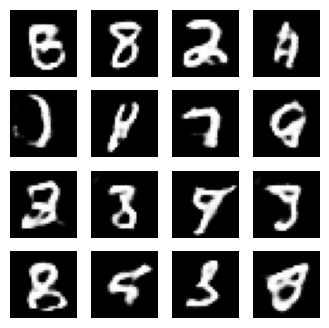

In [9]:
print("Starting Training...")
train(train_dataset, EPOCHS)